# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("nyc_high_school_data/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("nyc_high_school_data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("nyc_high_school_data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=True)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations[survey_fields])

DBN                NaN
rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:850: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Enable matplotlib to be shown inline

In [11]:
import matplotlib.pyplot as plt

# Run the following line so that matplotlib plots are displayed inline
%matplotlib inline

# Bar Plot showing correlations between survey fields and sat_score

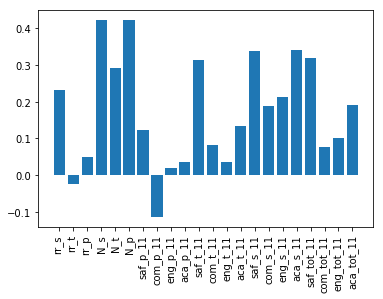

In [12]:
# in order to use the arange function, import it from numpy
from numpy import arange

fig, ax = plt.subplots()

bar_heights = correlations[survey_fields].values
bar_positions = arange(22)
tick_positions = range(0,22)

ax.bar(bar_positions, bar_heights)

ax.set_xticks(tick_positions)
ax.set_xticklabels(survey_fields, rotation=90)

plt.show()


# Observations from Survey Fields Bar Chart

## Fields with high correlation ( >= abs(.3))
- N_s: Number of student respondents
- N_t: Number of teacher respondents
- N_p: Number of parent respondents
- saf_t_11: Safety and respect score based on teacher responses
- saf_s_11: Safety and respect score based on student responses
- aca_s_11: Academic expectation based on student responses
- saf_tot_11: Safety and Respect total

## Observations on these fields

What appears interesting to me is that there appears to be a positive correlation with how safe the school feels and how well students do on their SATs. Perhaps a positive environment that fosters respect among the student body along with making folks feel safe allows students and teachers to focus more on bolstering their academics.

In addition, it appears that when students feel that their school expects them to do well, they appear to do better on their SAT scores. Perhaps the students in this case go to schools that do stress high scholastic achievement? Perhaps these students perceive this high expectation or impose this upon themselves but the school places the same emphasis as other schools on academics? This would be interesting to explore as this appears to tie into the whole "is it the teacher or is it the student?" debate on a student's overall success.

# Scatter plot on safety perception vs. SAT Scores

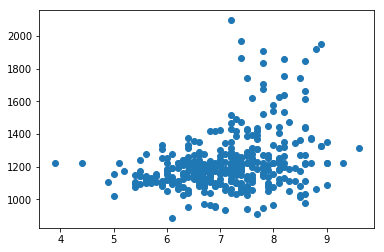

In [13]:
plt.scatter(x=combined["saf_t_11"],y=combined["sat_score"])
plt.show()

# Observations on scatter plot for safety perceptions vs. SAT Scores

It looks like there is a decent positive correlation. It looks like it's generally the same though across the board at an apparent average of 1200.

# Average Safety Score for Each District

In [14]:
school_dist_groupby = combined.groupby("school_dist")

school_dist_groupby = school_dist_groupby.agg(numpy.mean)

print(school_dist_groupby.head())

             SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
school_dist                                                         
01                                441.833333           473.333333   
02                                426.619092           444.186256   
03                                428.529851           437.997512   
04                                402.142857           416.285714   
05                                427.159915           438.236674   

             SAT Writing Avg. Score    sat_score  AP Test Takers   \
school_dist                                                         
01                       439.333333  1354.500000       116.681090   
02                       424.832836  1295.638184       128.908454   
03                       426.915672  1293.443035       156.183494   
04                       405.714286  1224.142857       129.016484   
05                       419.666098  1285.062687        85.722527   

             Total Exams Taken  

# Mapping out the average SAT scores by district using code written by Dataquest in a previous mession

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


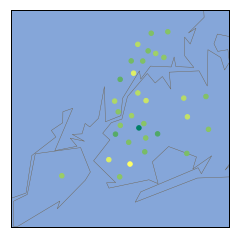

In [15]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = school_dist_groupby["lon"].tolist()
latitudes = school_dist_groupby["lat"].tolist()

m.scatter(x=longitudes,y=latitudes,s=20,zorder=2,latlon=True,c=school_dist_groupby["saf_t_11"],cmap="summer")

# Observations on the map of school districts and safety scores

It appears that the school districts with the highest saftey scores seem to be in northern Manhattan and southern Brooklyn.

# Racial Differences in SAT Scores

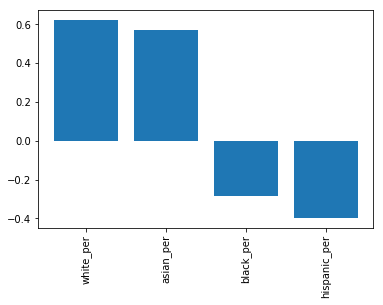

In [16]:
columns_pertaining_to_race = ["white_per","asian_per","black_per","hispanic_per"]

fig, ax = plt.subplots()

bar_heights = correlations[columns_pertaining_to_race].values
bar_positions = arange(4)
tick_positions = range(0,4)

ax.bar(bar_positions, bar_heights)

ax.set_xticks(tick_positions)
ax.set_xticklabels(columns_pertaining_to_race, rotation=90)

plt.show()



# Observations on the above graph

- It appears there is a strong correlation with sat scores and the percentage of students that are Caucasian or Asian.
- There also appears to be some correlation with sat scores and the percentage of students that are African-American or Hispanic

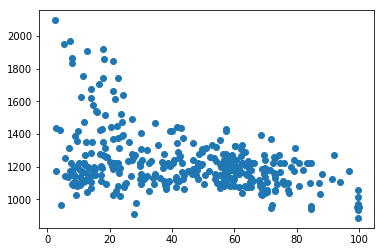

In [17]:
plt.scatter(x=combined["hispanic_per"],y=combined["sat_score"])
plt.show()

# Observation on the above graph
It appears there is a negative correlation between the percentage of students who identify as Hispanic in a school and SAT scores.

# Analysis of Schools with 95% or more of students who are Hispanic

In [18]:
schools_with_ninety_five_percent_hispanic_population = combined[combined["hispanic_per"] >= 95]

schools_with_ninety_five_percent_hispanic_population["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Observations from Google on a sample of the above schools
It appears that, from analyzing a sample, the schools above cater more towards children of immigrant families from Spanish-speaking countries.

# Analysis of Schools with 10% or less of students who are Hispanic and with an average student SAT score of 1800 or higher

In [19]:
less_than_ten_percent = combined[combined["hispanic_per"] <= 10]

more_than_1800 = less_than_ten_percent[less_than_ten_percent["sat_score"]>=1800]

more_than_1800["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Observations on the above high schools

From looking at their Wikipedia pages, I can see that all of these schools are specialized high schools which require students to take a test to get in.

# Gender and SAT Scores

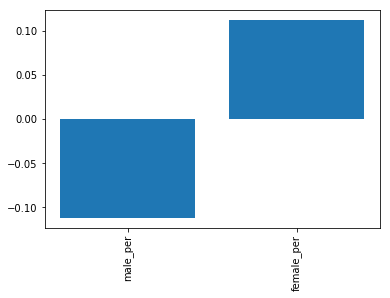

In [20]:
columns_pertaining_to_gender = ["male_per","female_per"]

fig, ax = plt.subplots()

bar_heights = correlations[columns_pertaining_to_gender].values
bar_positions = arange(2)
tick_positions = range(0,2)

ax.bar(bar_positions, bar_heights)

ax.set_xticks(tick_positions)
ax.set_xticklabels(columns_pertaining_to_gender, rotation=90)

plt.show()

# Observations on the above graph
It appears that there is a slight negative correlation between the percentage of students who are male and SAT scores. On the flip side, there appears to be a sligth positive correlation between the percentage of students who are female and SAT scores.

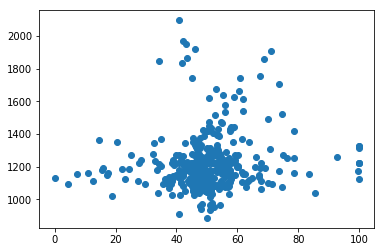

In [21]:
plt.scatter(x=combined["female_per"],y=combined["sat_score"])
plt.show()

# Observations on the above graph
It doesn't look like there is that much of a correlation.

# Analysis of Schools with 60% or more of students who identify as female and with an average student SAT score of 1700 or higher

In [22]:
more_than_sixty_percent = combined[combined["female_per"] >= 60]

more_than_1700 = more_than_sixty_percent[more_than_sixty_percent["sat_score"]>=1700]

more_than_1700["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Observations on the above high schools
It appears that, from looking at a sample, the above high schools cater more towards college-prep and the humanities.

In [23]:
combined["ap_per"]= combined["AP Test Takers "] / combined["total_enrollment"]

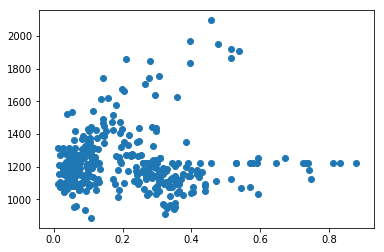

In [24]:
plt.scatter(x=combined["ap_per"],y=combined["sat_score"])
plt.show()

# Observations on the above graph
It looks like there's a bit of a positive correlation.